In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from time import time as timer
from scipy.signal.windows import dpss
from scipy.fft import rfft, rfftfreq

print("Packages Imported.")

Packages Imported.


In [2]:
sound = AudioSegment.from_mp3("sound_files/Cmaj7.mp3")

# get the frame rate
sample_rate = sound.frame_rate
# get amount of bytes contained in one sample
sample_size = sound.sample_width
# get channels
channels = sound.channels

print(f"Sample rate: {sample_rate}\nSample size: {sample_size}\nChannels: {channels}")

Sample rate: 44100
Sample size: 2
Channels: 1


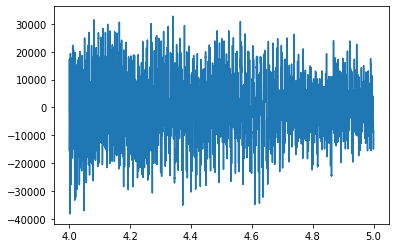

In [3]:
amplitudes = sound.get_array_of_samples()
times = np.arange(len(amplitudes))/sample_rate

# limit range to 4-5 s of recording
amp_range = np.array(amplitudes)[(times > 4) & (times < 5)]
times_range =  times[(times > 4) & (times < 5)]

# normalize amplitudes
norm_amps = (amp_range/(max(amp_range)))*32767

plt.plot(times_range, norm_amps);

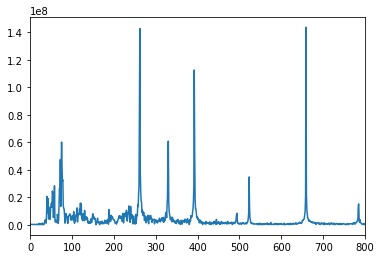

In [4]:
# plot traditional fourier transfrom
yf = rfft(norm_amps)
xf = rfftfreq(len(norm_amps), 1 / sample_rate)

plt.plot(xf, abs(yf))
plt.xlim([0,800])
plt.show()

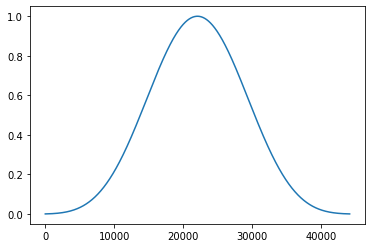

In [5]:
sig = norm_amps

beta = 10
plt.plot(np.kaiser(len(norm_amps), beta));

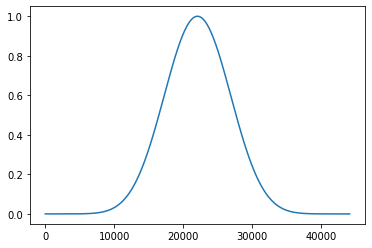

In [6]:
NW = 7
ss = dpss(len(norm_amps), NW)
plt.plot(ss);

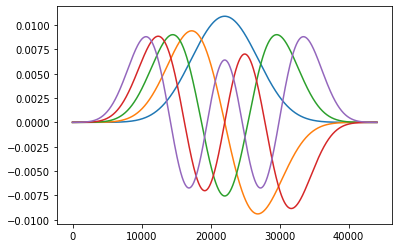

In [7]:
num_s = 5
ss = dpss(len(norm_amps), NW, num_s)

for s in ss:
    plt.plot(s);

In [8]:
# apply to signal and take fft
num_seq = 5
bandwith = 7
slepian_sequences = dpss(len(norm_amps), bandwith, num_seq)

psds = []

for seq in slepian_sequences:
    tapered = seq*norm_amps
    psd = np.abs(rfft(tapered))
    psds.append(psd)
    
multitaper_psd = np.array(psds).mean(axis=0)

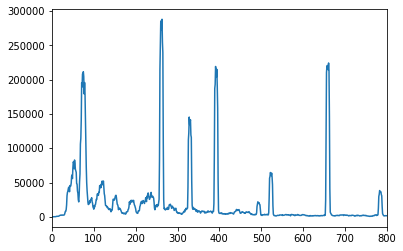

In [9]:
xf = rfftfreq(len(norm_amps), 1 / sample_rate)

plt.plot(xf, multitaper_psd)
plt.xlim([0,800])
plt.show()

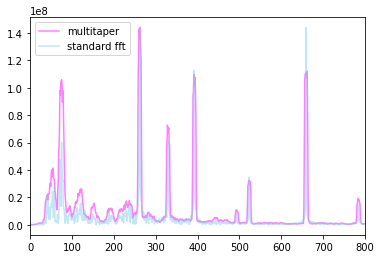

In [10]:
scaling_factor = 500 # multitapered shows lower overall power values

plt.plot(xf, multitaper_psd*scaling_factor, label='multitaper', color='magenta', alpha=0.5)
plt.plot(xf, np.abs(yf), label='standard fft', color='skyblue', alpha=0.5)
plt.xlim([0,800])
plt.legend()
plt.show()

In [11]:
# define a sample function

# sliding window perform multitaper across each deltaT
# check out existing implementations (MNE)

def multitaper_psd(signal, NW, kmax):
    
    slepian_sequences = dpss(len(signal), NW, kmax)

    psds = []

    for seq in slepian_sequences:
        tapered = seq*signal
        psd = np.abs(rfft(tapered))
        psds.append(psd)

    multitaper_psd = np.array(psds).mean(axis=0)
    
    return multitaper_psd

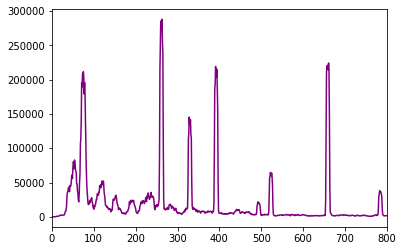

In [12]:
plt.plot(xf, multitaper_psd(norm_amps, 7, 5), color='purple')
plt.xlim([0,800])
plt.show()

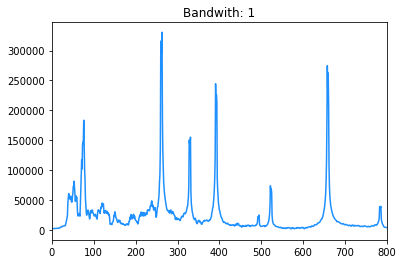

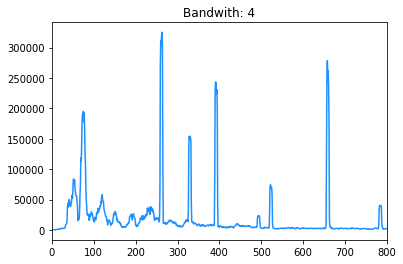

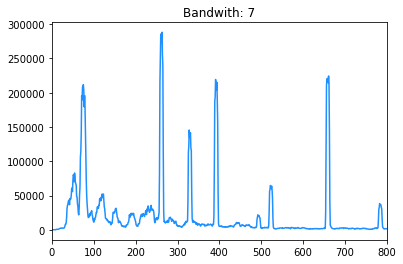

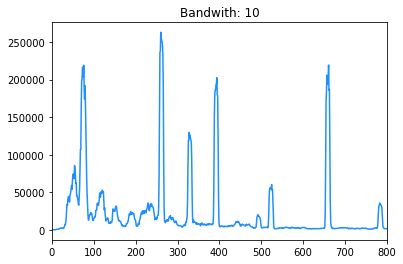

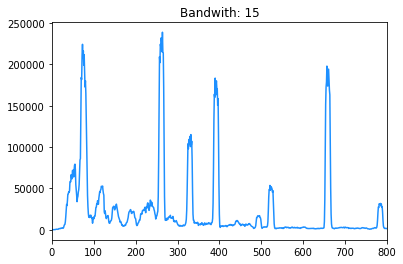

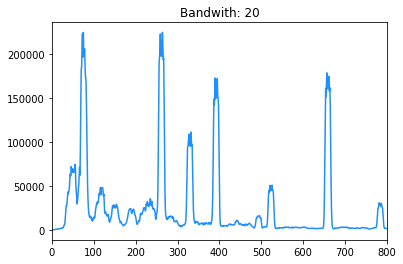

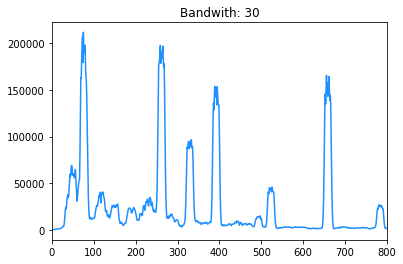

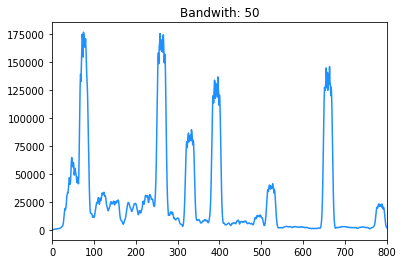

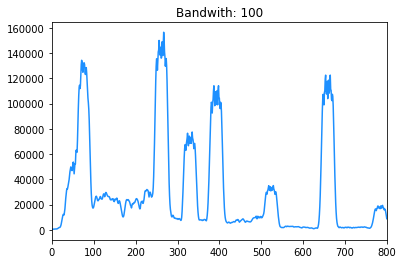

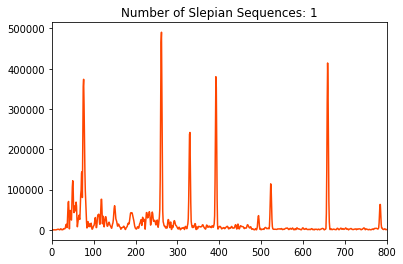

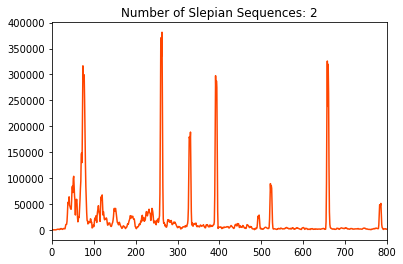

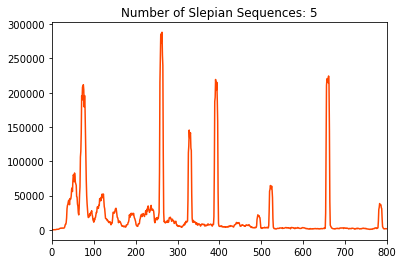

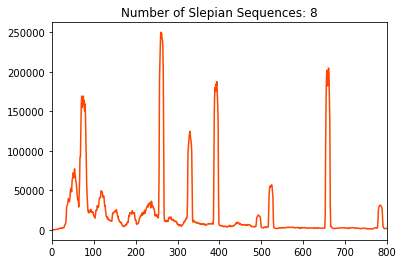

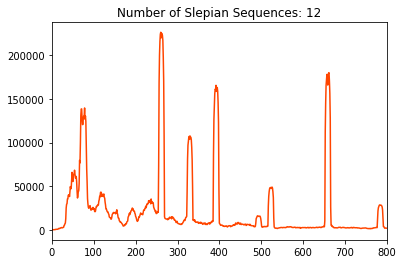

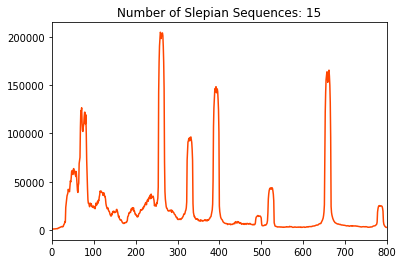

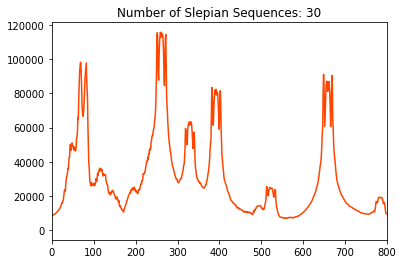

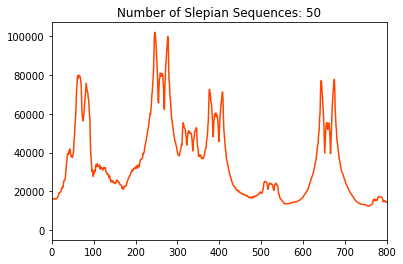

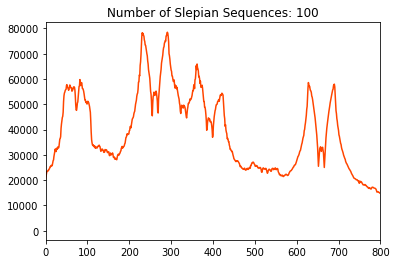

In [13]:
# what happens when you change parameters
bandwidths = [1,4,7,10,15,20,30,50,100]
num_seqs = [1,2,5,8,12,15,30,50,100]

for b in bandwidths:
    plt.plot(xf, multitaper_psd(norm_amps, b, 5), color='dodgerblue')
    plt.title(f"Bandwith: {b}")
    plt.xlim([0,800])
    plt.show()
    
for n in num_seqs:
    plt.plot(xf, multitaper_psd(norm_amps, 7, n), color='orangered')
    plt.title(f"Number of Slepian Sequences: {n}")
    plt.xlim([0,800])
    plt.show()

In [14]:
# develop sliding window func

In [21]:
def tfr_multitaper(signal, window_size, NW, kmax):
    
    output = []
    
    i = 0
    while i + window_size <= len(signal):
        output.append(multitaper_psd(signal[i:i+window_size], NW, kmax))
        i += window_size
        
    return output

In [32]:
# what parameters should be used here?
multitaper_psd(norm_amps[0:1000], 7, 5)

array([4.46364890e+04, 4.50880401e+04, 5.48585914e+04, 6.19554640e+04,
       6.65257037e+04, 6.54774005e+04, 7.37992679e+04, 7.15437453e+04,
       7.05729470e+04, 6.90822353e+04, 4.29810434e+04, 5.29448352e+04,
       5.41593769e+04, 5.20539804e+04, 5.13567121e+04, 4.89205696e+04,
       5.26345401e+04, 4.92661687e+04, 4.89588098e+04, 3.12640902e+04,
       1.26377806e+04, 1.04375114e+04, 7.51477776e+03, 7.22651289e+03,
       7.37685828e+03, 5.95966126e+03, 8.60823172e+03, 8.45186519e+03,
       8.64205969e+03, 6.87629042e+03, 6.96095432e+03, 5.14956527e+03,
       6.53789393e+03, 6.45310445e+03, 7.38789561e+03, 5.60344125e+03,
       5.54832999e+03, 5.61133058e+03, 5.81035031e+03, 6.25372080e+03,
       4.51462900e+03, 3.48881890e+03, 3.12143226e+03, 2.97431107e+03,
       2.68702254e+03, 2.78036638e+03, 2.12747599e+03, 1.82264982e+03,
       1.74484681e+03, 1.17611255e+03, 9.16731240e+02, 6.58568008e+02,
       4.91134187e+02, 4.75276843e+02, 4.63128038e+02, 3.79788422e+02,
      

In [16]:
def tfr_multitaper_epochs(signal, epochs, NW, kmax):
    
    output = []
    
    for epoch in epochs:
        output.append(multitaper_psd(signal[epoch[0]:epoch[1]], NW, kmax))
        i += window_size
        
    return np.array(output) # assumes uniformly sized epochs